# Toxic Comment Classification Challenge: Kaggle
[Link to the Kaggle competition page](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge)

This is a classic text classification problem, where one is given a corpus of text documents with labelled classes, and one has to perform supervised machine learning to first train the data, and then classify unseen documents.

In [1]:
# Import thr necessary libraries
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display, HTML

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize, RegexpTokenizer

import gensim
from gensim.models.ldamodel import LdaModel
from gensim.corpora import Dictionary

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB, GaussianNB

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [2]:
train = pd.read_csv('train.csv')

In [3]:
test = pd.read_csv('test.csv')

In [4]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


 - No missing values! How many times do you get that? All the non-toxic text is already labelled as 0.

### Distribution of hate comments

In [6]:
count_labels_ser = train.select_dtypes(include=np.number).sum(axis=0)
#data.select_dtypes(include=np.number).isin([1]).any(axis=1).sum()
sum_toxic_comments = train.select_dtypes(include=np.number).apply(lambda row: any(row) == 1, axis=1).sum()
print('Total number of hate texts = {}, out of {}'.format(sum_toxic_comments, train.shape[0]))
print('Total number of clean comments: {}, out of {}'.format(train.shape[0] - sum_toxic_comments, train.shape[0]))

Total number of hate texts = 16225, out of 159571
Total number of clean comments: 143346, out of 159571


Text(0, 0.5, '%age of occurence')

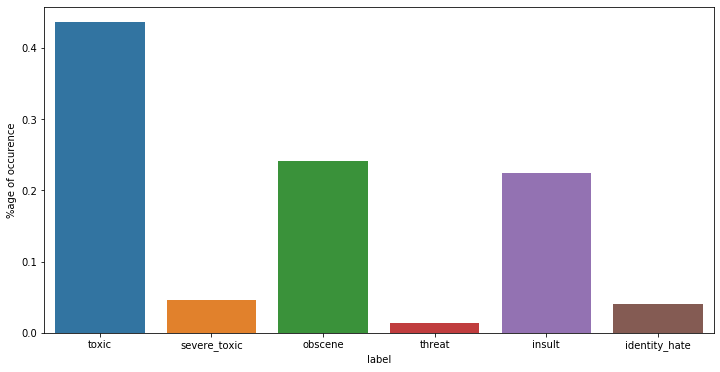

In [7]:
fig = plt.figure(figsize=(12,6))
sns.barplot(x=count_labels_ser.index,y=count_labels_ser/count_labels_ser.sum())
plt.xlabel('label')
plt.ylabel('%age of occurence')

The data set is imbalanced, as you would expect. There are much fewer `severe_toxic` and `threat` comments than there are plain `toxic` ones.

- Next we will take a look at some random comments from each class of toxicity.

In [8]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
for class_name in class_names:
    rand_text = np.random.choice(train[train[class_name]==1].index,size=1)[0] # Select a random comment from each class
    print('Example of {} text\n'.format(class_name), train.iloc[rand_text,1],'\n')

Example of toxic text
 hey dead set Fuck Head 

Example of severe_toxic text
 Who are YOU to tell ME??!! I'll do WHAT I like WHEN I like...cocksucker!! 

Example of obscene text
 i dont give a fuck nigga 

Example of threat text
 Block Me! I DARE YOU 

Hey, don't tell me what I can and can't do, go ahead and block me, cause if you do, I will have this whole damn website shut down for good. So try me!!!    Wweppvguy 

Example of insult text
 Shut the fuck you little anon, you don't know anything! 

Example of identity_hate text
 fucking 

faggot

hopefully somone rapes or eats you soon you fucking idiot 



#### Lot of hate lurking there, beware!

- A particular comment can have multiple labels for 'toxicity'. For e.g.

In [9]:
train.iloc[6]

id                                           0002bcb3da6cb337
comment_text     COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK
toxic                                                       1
severe_toxic                                                1
obscene                                                     1
threat                                                      0
insult                                                      1
identity_hate                                               0
Name: 6, dtype: object

In [10]:
for col in train.columns[3:]:
    display(pd.crosstab(train['toxic'],train[col], margins=True))

severe_toxic,0,1,All
toxic,,,
0,144277,0,144277
1,13699,1595,15294
All,157976,1595,159571


obscene,0,1,All
toxic,,,
0,143754,523,144277
1,7368,7926,15294
All,151122,8449,159571


threat,0,1,All
toxic,,,
0,144248,29,144277
1,14845,449,15294
All,159093,478,159571


insult,0,1,All
toxic,,,
0,143744,533,144277
1,7950,7344,15294
All,151694,7877,159571


identity_hate,0,1,All
toxic,,,
0,144174,103,144277
1,13992,1302,15294
All,158166,1405,159571


In [11]:
train['len_comment'] = train['comment_text'].apply(len)
train.loc[train.iloc[:,2:8].sum(axis=1)>=1].head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,len_comment
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0,44
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0,319
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0,57
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1,648
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0,40


mean character length of toxic comments: 295.24604420034
mean character length of clean comments: 404.5493391185012


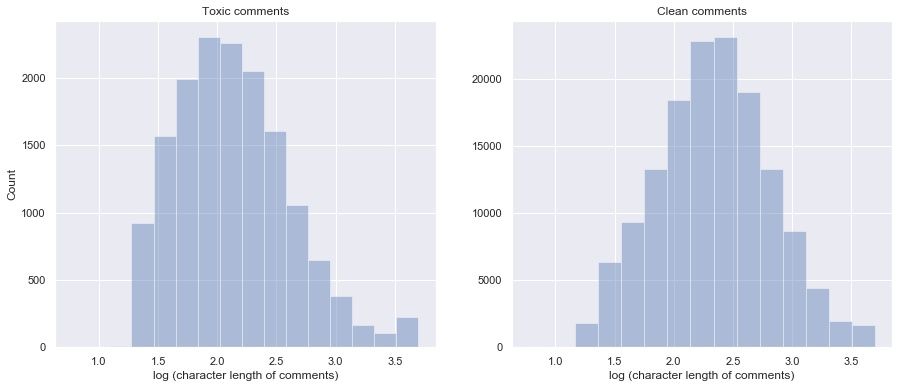

In [12]:
sns.set()
fig, ax = plt.subplots(1,2,sharex=True, figsize=(15,6))
_=sns.distplot(np.log10(train.loc[train.toxic==1,'len_comment']),kde=False, bins=15,ax=ax[0])
_=ax[0].set_xlabel('log (character length of comments)')
_=ax[0].set_ylabel('Count')
_=ax[0].set_title('Toxic comments')

_=sns.distplot(np.log10(train.loc[train.toxic==0,'len_comment']),kde=False, bins=15,ax=ax[1])
_=ax[1].set_xlabel('log (character length of comments)')
_=ax[1].set_title('Clean comments')
print('mean character length of toxic comments: {}'.format(train.loc[train.toxic==1,'len_comment'].mean()))
print('mean character length of clean comments: {}'.format(train.loc[train.toxic==0,'len_comment'].mean()))

#### The clean comments are longer than the toxic comments.

In [13]:
train_text = train['comment_text']
test_text = test['comment_text']

In [14]:
import string 
punctuation_set = set(string.punctuation)

In [15]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'([a-zA-Z]+)') 
def preprocess_comment(comment_str):
    '''
    This function preprocesses the comments and sets them up for vectorization.
    Input: comment string
    Returns: A string after converting the words to lowercase, removing punctuations, and lemmatizing each word
    '''
    comment=re.sub(r"(\d{1,3}\.){1,3}\d{1,3}","",comment_str)  #remove ip's
    words = [word for word in tokenizer.tokenize(comment.lower()) if not word in stop_words]  # convert to lowercase and remove stopwords
    clean_words = [word for word in words if word not in punctuation_set] #remove puntuations
    lemmatized_sentence = ' '.join([lemmatizer.lemmatize(word,pos='v') for word in clean_words if len(word)>2]) ## lemmatization
    return lemmatized_sentence         

In [16]:
print('Original text:\n {}'.format(train_text[1010]))
print('After cleaning:\n {}'.format(preprocess_comment(train_text[1010])))

Original text:
 "
 The only person claiming edit warring is you.  I urge you again to moderate your tone and abide by civility.   Padding Romm's entry with insubstantial fluff like what his brother does for a living and lengthy descriptions of projects he ""helped with"" has no place in an encyclopedia entry.   "
After cleaning:
 person claim edit war urge moderate tone abide civility pad romm entry insubstantial fluff like brother live lengthy descriptions project help place encyclopedia entry


In [17]:
train_text = train_text.apply(lambda comment: preprocess_comment(comment))

In [18]:
test_text = test_text.apply(lambda comment: preprocess_comment(comment))

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [20]:
word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    strip_accents='unicode',
    analyzer='word',
#    preprocessor= preprocess_comment,
    max_df = 0.7,
    ngram_range=(1, 2),
    max_features=40000)
word_vectorizer.fit(train_text)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=0.7, max_features=40000,
                min_df=1, ngram_range=(1, 2), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents='unicode',
                sublinear_tf=True, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [21]:
import time
start = time.time()
train_word_features = word_vectorizer.transform(train_text)
test_word_features = word_vectorizer.transform(test_text)
end = time.time()
print((end-start)/60,'mins')

0.3406836191813151 mins


In [22]:
print('Train matrix shape: {}'.format(train_word_features.shape))
print('Test matrix shape: {}'.format(test_word_features.shape))

Train matrix shape: (159571, 40000)
Test matrix shape: (153164, 40000)


In [23]:
feature_names = word_vectorizer.get_feature_names()

### Visualizing tf-idf features

In [24]:
def top_tfidf_feats(row, features, top_n=10):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df
def top_feats_in_doc(X, features, row_id, top_n=10):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [25]:
rand_index = np.random.choice(range(len(train)), size=1)[0]
print(train.loc[rand_index, 'comment_text'])
top_feats_in_doc(train_word_features, feature_names, rand_index, top_n=5)

"
Agreed, but Black's evidence from the third dynasty of ur dates almost contemporaneously with the tablets, highly suggesting the word was used in this way. We could put dozens of fringe writers in to source a stubby kharsag page, maybe best to single source Barton, who was the original proliferator. I've come over a bit funny since my dog died last week, a bit like Ezekiel's wife dying at my age, but anyhow, I've got annoyed and wrote this to Edmund (who still wants to sell books) and Karl (who still won't give me the photos and video) when drunk, thought you might like a read (and any advice always welcome) 

Right,
 
I've now become an expert at near east archaeology, it took me a while to read up and write all the wikipedia articles about the sites, archaeologists and official bodies that we need to contact to get things going.
 
What we need to do is to contact the people that I am gradually creating a database of on Wikipedia with a CONSTANTLY updating thesis of the Pre pottery 

,feature,tfidf
0,thesis,0.192177
1,brien,0.151257
2,need contact,0.148107
3,archaeology,0.135784
4,prepare,0.130667


In [26]:
def cross_val(clf,Xtrain=train_word_features, cv=3):
    scores = []
    class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
    for class_name in class_names:
        train_target = train[class_name]
        cv_score = np.mean(cross_val_score(clf, Xtrain, train_target, cv=cv, scoring='roc_auc'))
        scores.append(cv_score)
        print('CV score for class {} is {}'.format(class_name, cv_score))
    print('Mean CV score is {}'.format(np.mean(scores)))

In [27]:
clf_NB = MultinomialNB(alpha=0.1)
clf_logreg = LogisticRegression(C=0.2, solver= 'sag')
print('--------Naive Bayes----------\n')
cross_val(clf_NB,cv=5)
print('--------Logistic Regression----------\n')
cross_val(clf_logreg,cv=5)

--------Naive Bayes----------

CV score for class toxic is 0.9513849174820403
CV score for class severe_toxic is 0.9759229253621238
CV score for class obscene is 0.9616651659367653
CV score for class threat is 0.9503530482200053
CV score for class insult is 0.9594859217305199
CV score for class identity_hate is 0.953369463450486
Mean CV score is 0.9586969070303235
--------Logistic Regression----------

CV score for class toxic is 0.9643634901244755
CV score for class severe_toxic is 0.9845209716957433
CV score for class obscene is 0.9830274795350565
CV score for class threat is 0.9770051725620835
CV score for class insult is 0.9733577948961495
CV score for class identity_hate is 0.9700085187050626
Mean CV score is 0.9753805712530953


In [28]:
from sklearn.model_selection import GridSearchCV

In [29]:
import xgboost as xgb

In [30]:
xgb_model = xgb.XGBClassifier(max_depth=5, n_estimators=300, n_jobs=-1,random_state=42)
cross_val(xgb_model)

CV score for class toxic is 0.9511602489013405
CV score for class severe_toxic is 0.9763245278767293
CV score for class obscene is 0.9808496900632161
CV score for class threat is 0.9648371227538798
CV score for class insult is 0.9664116531135017
CV score for class identity_hate is 0.9602509167762593
Mean CV score is 0.9666390265808212


- **XGBoost surprisingly does not perform well in this task! I agree that I haven't followed a rigorous method of grid search to find the optimum set of hyperparameters because of my computing limitations, but those who have tried that approach weren't successful either.**

In [31]:
submission = pd.DataFrame.from_dict({'id': test['id']})
classifier = clf_logreg
for class_name in class_names:
    classifier.fit(train_word_features, train[class_name])
    submission[class_name] = classifier.predict_proba(test_word_features)[:, 1]
submission.to_csv('submission.csv', index=False)

In [32]:
def plot_and_return_top_features(classifier, vectorizer, class_name, top_features=20):
    """
    Plot the top features in a binary classification model and remove possible overlap.

    Adapted from https://medium.com/@aneesha/visualising-top-features-in-linear-svm-with-scikit-learn-and-matplotlib-3454ab18a14d
    and https://stackoverflow.com/a/26980472 by @kjam
    """
    class_labels = classifier.classes_
    feature_names = vectorizer.get_feature_names()
    topn_class1 = sorted(zip(classifier.coef_[0], feature_names))[:top_features]
    topn_class2 = sorted(zip(classifier.coef_[0], feature_names))[-top_features:]
    top_coefficients = np.hstack([topn_class1, topn_class2])
    if set(topn_class1).union(topn_class2):
        top_coefficients = topn_class1
        for ce in topn_class2:
            if ce not in topn_class1:
                top_coefficients.append(ce)

    plt.figure(figsize=(15, 5))
    colors = ['red' if c < 0 else 'blue' for c in [tc[0] for tc in top_coefficients]]
    plt.bar(np.arange(len(top_coefficients)), [tc[0] for tc in top_coefficients], color=colors)
    plt.xticks(np.arange(len(top_coefficients)),
               [tc[1] for tc in top_coefficients], rotation=60, ha='right')
    plt.title('{} comments'.format(class_name))
    plt.ylabel('Feature coefficient values')
    plt.show()
    return top_coefficients


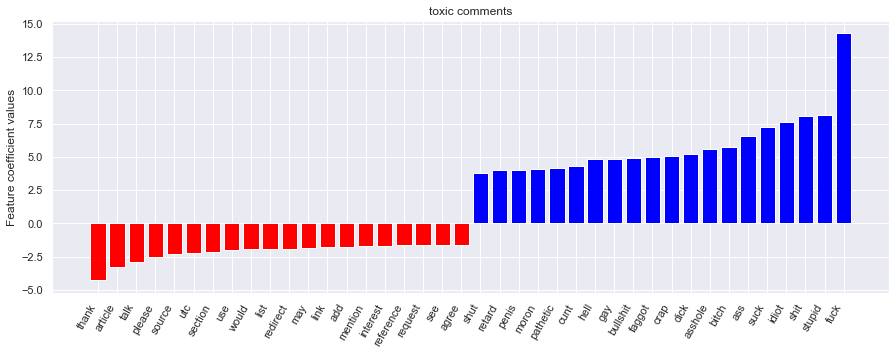

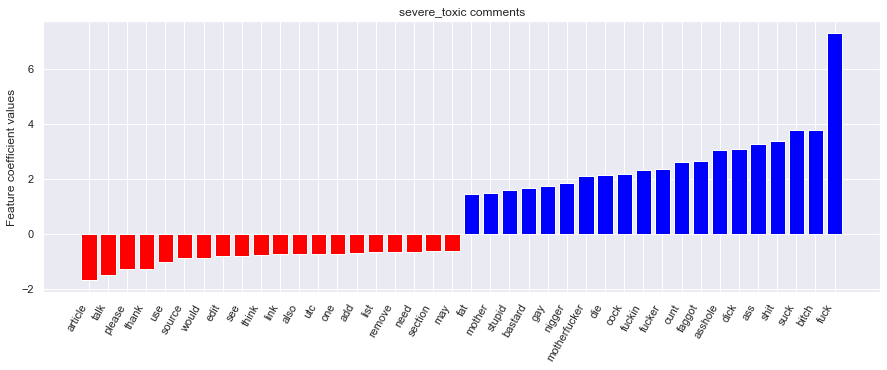

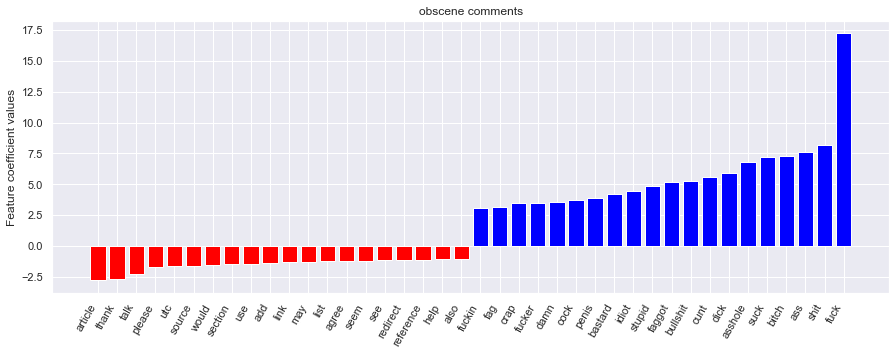

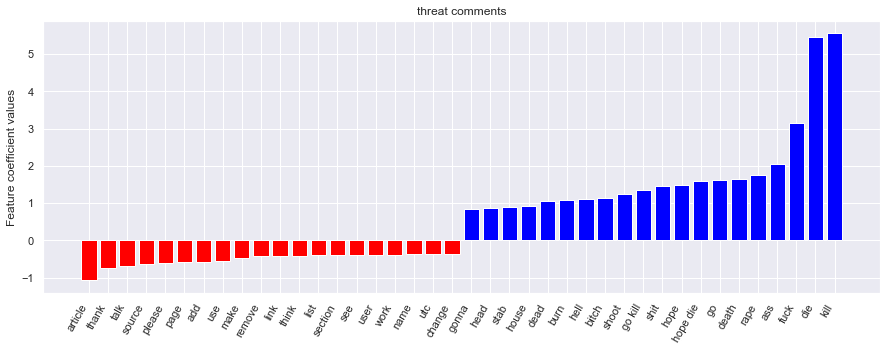

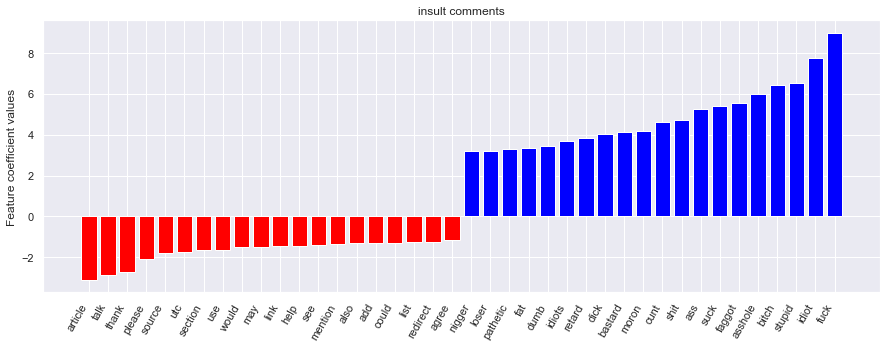

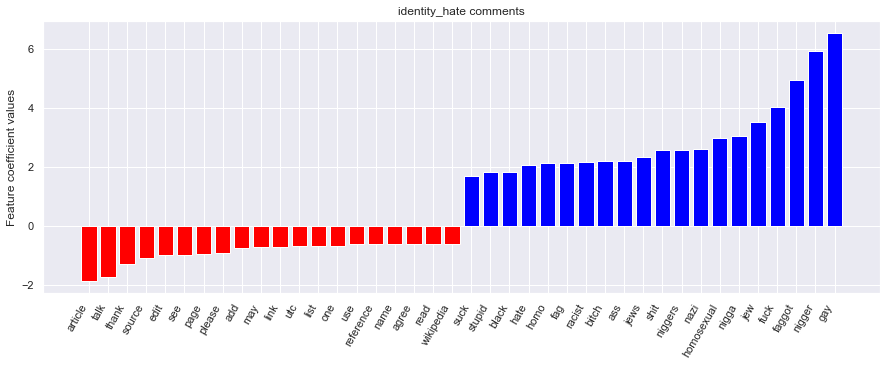

In [33]:

for class_name in class_names:
    logreg = LogisticRegression(C=0.2, solver= 'sag')
    logreg.fit(train_word_features, train[class_name])
    _=plot_and_return_top_features(logreg, word_vectorizer, class_name, 20)

## Topic modelling

In [34]:
tokenized_clean_train_text = [word_tokenize(doc) for doc in train_text]
gensim_dict = Dictionary(tokenized_clean_train_text)
gensim_dict.save('dictionary.dict')

/Users/debashis/anaconda3/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [35]:
print(train_text[4657])  #random comment
print('The id for the word \'wikipedia\' is: {}'.format(gensim_dict.token2id['wikipedia']))   # finding the id for a word from the gensim dictionary

mean mean forever ever block wikipedia huh well thats disappoint
The id for the word 'wikipedia' is: 85


In [36]:
#Now convert each document into the bag-of-words (BoW) format = list of (token_id, token_count).
corpus = [gensim_dict.doc2bow(doc) for doc in tokenized_clean_train_text]
gensim.corpora.MmCorpus.serialize('corpus.mm', corpus)

In [37]:
num_topics=5
start = time.time()
lda = LdaModel(corpus, id2word=gensim_dict, num_topics=num_topics,chunksize=5000, random_state=42)
#lda.save('lda_5_topics.ldamodel')
print((time.time() - start)/60, 'mins')

1.4181474645932515 mins


In [38]:
lda.print_topics(num_words=10)

[(0,
  '0.012*"block" + 0.011*"edit" + 0.011*"make" + 0.008*"say" + 0.007*"know" + 0.007*"like" + 0.007*"one" + 0.007*"get" + 0.006*"think" + 0.006*"people"'),
 (1,
  '0.036*"page" + 0.029*"article" + 0.026*"talk" + 0.026*"wikipedia" + 0.019*"edit" + 0.018*"please" + 0.016*"thank" + 0.009*"help" + 0.009*"add" + 0.008*"delete"'),
 (2,
  '0.027*"article" + 0.024*"source" + 0.019*"use" + 0.017*"image" + 0.011*"wikipedia" + 0.010*"link" + 0.009*"page" + 0.009*"list" + 0.009*"add" + 0.008*"reference"'),
 (3,
  '0.007*"article" + 0.007*"say" + 0.007*"one" + 0.006*"would" + 0.006*"think" + 0.004*"people" + 0.004*"also" + 0.004*"state" + 0.004*"make" + 0.004*"time"'),
 (4,
  '0.024*"fuck" + 0.013*"lol" + 0.009*"suck" + 0.009*"http" + 0.009*"faggot" + 0.008*"hate" + 0.007*"fat" + 0.007*"jew" + 0.006*"aid" + 0.006*"like"')]

In [39]:
import pyLDAvis
pyLDAvis.enable_notebook()
import pyLDAvis.gensim

In [40]:
#lda = gensim.models.LdaModel.load('lda_10_topics.ldamodel')
#corpus = gensim.corpora.MmCorpus('corpus.mm')
#gensim_dict = gensim.corpora.Dictionary.load('dictionary.dict')

In [41]:
start = time.time()
lda_display = pyLDAvis.gensim.prepare(lda, corpus, gensim_dict)
end = time.time()
print((end-start)/60,'mins')

/Users/debashis/anaconda3/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


115.89040588140487 mins


In [42]:
pyLDAvis.display(lda_display)

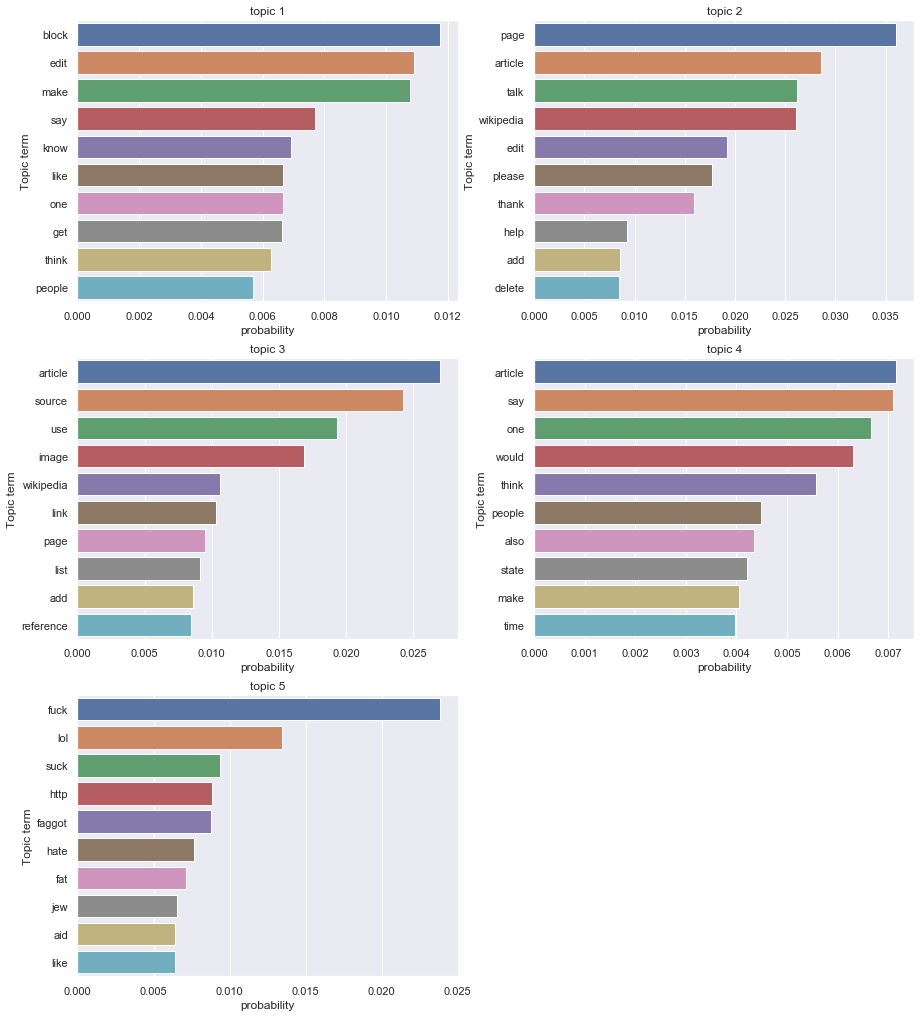

In [50]:
fig=plt.figure(figsize=(15,30))
for i in range(num_topics):
    df=pd.DataFrame(lda.show_topic(i), columns=['term','prob']).set_index('term')    
    plt.subplot(5,2,i+1)
    plt.title('topic '+str(i+1))
    sns.barplot(x='prob', y=df.index, data=df)
    plt.xlabel('probability')
    plt.ylabel('Topic term')

### Find the topic of a new document from the test set

In [54]:
newdoc = test_text[3434]
#newdoc = 'PENIS VAGINA YOU SUCK FAGGOT ASSHOLES AT WIKIPEDIA '
print(newdoc)
new_doc_bow = gensim_dict.doc2bow(word_tokenize(preprocess_comment(newdoc)))

confuse mind noroton single handedly veto rick block proposal like word criticism work way around due regard think


In [55]:
topic_proba_sorted = sorted(lda.get_document_topics(new_doc_bow),key = lambda row: row[1],reverse=True)
print(topic_proba_sorted)
ind_max_proba_topic = topic_proba_sorted[0][0]

[(0, 0.59685826), (3, 0.26130992), (2, 0.12037969), (1, 0.010840536), (4, 0.01061157)]


In [56]:
print('Topic words for the given document:\n {}'.format(', '.join([row[0] for row in lda.show_topic(ind_max_proba_topic)])))

Topic words for the given document:
 block, edit, make, say, know, like, one, get, think, people
